In [1]:
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import multiprocessing as mp
from multiprocessing import Pool
import time
from functools import partial
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from summa.summarizer import summarize

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


***

# 데이터 불러오기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

# 데이터 샘플 확인

In [3]:
data.sample(10)

,headlines,text
29649,"Pluto could be made up of billions of comets, ...",Dwarf planet Pluto was formed by agglomeration...
10450,"95-yr-old gets up during his funeral, says sle...","A 95-year-old man, who was declared dead by a ..."
89032,Italy rescues 480 migrants in Mediterranean Sea,Italian rescuers saved over 480 asylum seekers...
29429,Floating post offices at Kumbh to make stamps ...,Floating post offices will be set up in the Ga...
25530,PNB collected Ã¢ÂÂ¹151cr as minimum balance p...,Fraud-hit PNB has realised Ã¢ÂÂ¹151.66 crore ...
40232,Kerala Public Service Commission defers exams ...,The Kerala Public Service Commission has postp...
62670,Sreesanth should back his claims of BCCI bias:...,India's World Cup-winning captain Kapil Dev ha...
32083,"Rhea shares pic with Sonam, addresses her as S...",Rhea Kapoor took to Instagram to share a pictu...
49934,Trump rejection of talks will cause more blood...,After US President Donald Trump rejected peace...
46834,Mukesh Ambani's Reliance Jio to invest Ã¢ÂÂ¹1...,Reliance Industries Chairman Mukesh Ambani has...


In [4]:
data.describe()

,headlines,text
count,98401,98401
unique,98280,98360
top,Why is England-Australia Test series called 'T...,English astronomer Arthur Eddington used 1919'...
freq,3,2


In [5]:
print('텍스트 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('헤드라인 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

텍스트 열에서 중복을 배제한 유일한 샘플의 수 : 98360
헤드라인 열에서 중복을 배제한 유일한 샘플의 수 : 98280


# 중복 데이터 삭제

In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


# Null 데이터 유무 확인

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


# 정규화 사전 불러오기

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


# 불용어 불러오기

In [9]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

# 이미 약어를 정규화를 하는 만큼 불용어 정리 (연산 속도 개선)

In [10]:
contractions_keys = contractions.keys()

In [11]:
stopwords_temp = [x for x in stopwords.words('english') if x not in contractions_keys]

In [12]:
print(len(stopwords_temp))
stopwords_temp

154


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no'

In [13]:
stopwords_new = ['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 'not',
 'only',
 'own',
 'same',
 'so',
 'than',
 'too',
 'very',
 'can',
 'will',
 'just',
 'don',
 'should',
 'now']

***

# 데이터 전처리

In [14]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords_new if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [15]:
start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()

  text_data_split = np.array_split(data, num_cores)
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text'])
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False)
print(clean_headlines)

7.492077589035034  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak 

# 전처리 후 Null 데이터 확인

In [16]:
data['text'] = clean_text
data['headlines'] = clean_headlines
data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

# 데이터 길이 최소, 최대, 평균, 표준편차 확인

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.13773891825946
텍스트의 표준편차 : 3.8047266160887654
텍스트의 제3사분위수 : 38.0
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534
헤드라인의 표준편차 : 1.3900944321771693
헤드라인의 제3사분위수 : 10.0


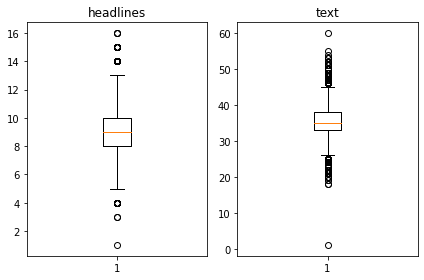

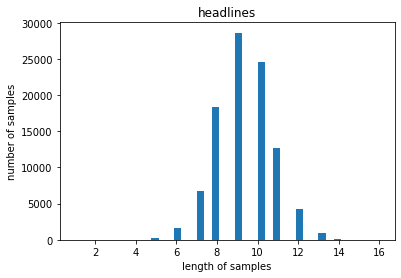

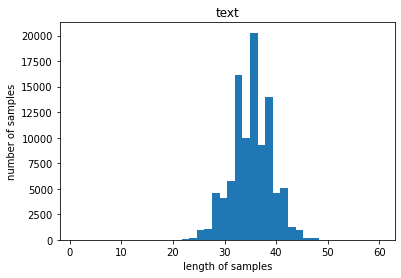

In [17]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('텍스트의 표준편차 : {}'.format(np.std(text_len)))
print('텍스트의 제3사분위수 : {}'.format(np.quantile(text_len, 0.75)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('헤드라인의 표준편차 : {}'.format(np.std(headlines_len)))
print('헤드라인의 제3사분위수 : {}'.format(np.quantile(headlines_len, 0.75)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 제3사분위수를 기준으로 최대 길이 설정

In [18]:
text_max_len = 38
headlines_max_len = 10

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 38 이하인 샘플의 비율: 0.813531923546157
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


# 선정한 최대 길이보다 큰 데이터 삭제

In [21]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65081


# 시작 토큰, 종료 토큰 추가

In [22]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair won ramgarh a...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


# 인코더 인풋, 디코더 인풋, 디코더 타겟 데이터로 분류

In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[42945 13654 34472 ... 12880 13461 27675]


In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 훈련용 데이터와 검정용 데이터로 분할

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13016


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52065
훈련 레이블의 개수 : 52065
테스트 데이터의 개수 : 13016
테스트 레이블의 개수 : 13016


***

# 인코더 데이터 토큰화

In [28]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [29]:
threshold = 6
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 57148
등장 빈도가 5번 이하인 희귀 단어의 수: 37795
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19353
단어 집합에서 희귀 단어의 비율: 66.13529782319591
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.013836757055342


# 희귀 단어 제외한 단어 집합 크기에 맞춰 단어 수 설정 : 19000

In [30]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [31]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
print(encoder_input_train[:3])

[[12, 977, 2850, 4874, 4948, 57, 400, 2400, 59, 145, 1042, 478, 530, 87, 21, 565, 147, 2122, 458, 3724, 59, 909, 12, 1555, 2, 516, 1578, 1499, 39, 385, 556, 21, 357, 1286, 12, 54], [172, 2532, 4701, 7361, 6307, 4388, 809, 193, 8875, 6, 20, 17895, 36, 66, 17895, 2532, 3356, 6307, 110, 64, 9132, 230, 8875, 3203, 2533, 917, 66, 2711, 9393, 171, 724], [14670, 95, 4146, 3204, 204, 1727, 8, 9976, 1477, 178, 2775, 2181, 14670, 1, 1540, 2775, 2181, 6909, 297, 1084, 88, 120, 580, 51, 263, 14670, 94, 13876, 3846, 4146, 3238, 2132, 2900, 2170, 178, 2384, 317]]


# 디코더 데이터 토큰화

In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold = 4
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 25768
등장 빈도가 3번 이하인 희귀 단어의 수: 15002
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10766
단어 집합에서 희귀 단어의 비율: 58.219497050605405
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.4459296780951485


# 희귀 단어 제외 단어 집합 크기에 맞춰 단어 수 설정 : 10000

In [34]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 759, 119, 990, 236, 4684, 5, 398, 1524], [1, 14, 1974, 2247, 1290, 5975, 1550, 42, 4, 5246], [1, 159, 9444, 13, 2441, 254, 1326, 782], [1, 1327, 274, 1587, 4, 830, 180], [1, 3, 291, 365, 740, 77, 1268, 8380, 6, 3595, 5602]]
target
decoder  [[759, 119, 990, 236, 4684, 5, 398, 1524, 2], [14, 1974, 2247, 1290, 5975, 1550, 42, 4, 5246, 2], [159, 9444, 13, 2441, 254, 1326, 782, 2], [1327, 274, 1587, 4, 830, 180, 2], [3, 291, 365, 740, 77, 1268, 8380, 6, 3595, 5602, 2]]


In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [36]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52065
훈련 레이블의 개수 : 52065
테스트 데이터의 개수 : 13016
테스트 레이블의 개수 : 13016


# 패딩 진행

In [37]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

***

# 모델링

In [38]:
embedding_dim = 128
hidden_size = 512

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.5, recurrent_dropout = 0.5)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.5)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)

In [39]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5, recurrent_dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [40]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [41]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 128)      2432000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 38, 512), (N 1312768     embedding[0][0]                  
______________________________________________________________________________________________

In [42]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=128, callbacks=[es], epochs=50)

Epoch 1/50
407/407 [==============================] - 245s 580ms/step - loss: 6.7149 - val_loss: 5.9427
Epoch 2/50
407/407 [==============================] - 234s 576ms/step - loss: 5.9244 - val_loss: 5.6028
Epoch 3/50
407/407 [==============================] - 235s 577ms/step - loss: 5.5187 - val_loss: 5.3068
Epoch 4/50
407/407 [==============================] - 234s 576ms/step - loss: 5.1455 - val_loss: 5.0628
Epoch 5/50
407/407 [==============================] - 235s 577ms/step - loss: 4.7951 - val_loss: 4.8494
Epoch 6/50
407/407 [==============================] - 235s 577ms/step - loss: 4.4692 - val_loss: 4.6917
Epoch 7/50
407/407 [==============================] - 235s 576ms/step - loss: 4.1757 - val_loss: 4.5952
Epoch 8/50
407/407 [==============================] - 234s 576ms/step - loss: 3.9143 - val_loss: 4.5095
Epoch 9/50
407/407 [==============================] - 234s 576ms/step - loss: 3.6730 - val_loss: 4.4735
Epoch 10/50
407/407 [==============================] - 235s 579m

# 학습 곡선

## 학습곡선을 확인하며 다양한 형태의 모델 시도

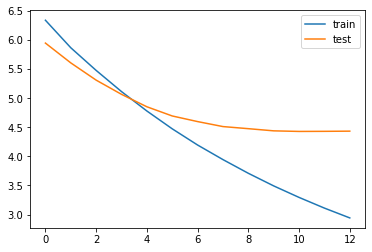

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 인퍼런스 모델 구현

In [45]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# 요약문장 생성

In [49]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : bjp spokesperson sambit patra wednesday said corrupt jailed law taking course see reason political party cry vendetta law vendetta statement comes congress slammed bjp chidambaram son karti chidambaram arrest money laundering case calling bjp government vendetta 
실제 요약 : this is law not bjp on karti chidambaram arrest 
예측 요약 :  bjp mp demands resignation of congress leaders


원문 : indian army wednesday rescued us citizen got stuck rock height feet ground level himachal pradesh kangra district indian army helicopter used rescue paraglider sustained several injuries accident later shifted delhi 
실제 요약 : army rescues us stuck at ft in himachal 
예측 요약 :  indian army officer rescues indian army stranded in nepal


원문 : british youtuber shared video social media major facebook london headquarters unlocked side entrance man claims security played game pool facebook office youtuber also gained unauthorised access bbc studio live broadcast earlier month 
실제 요약 : youtuber sneaks into facebo

예측 요약 :  catalan protester suspended for years


원문 : state bank india monday hiked fixed deposit interest rates select crore year years provide interest earlier senior citizens get deposits years years interest rate revised 
실제 요약 : sbi raises fixed deposit interest rates 
예측 요약 :  gst collection to be revised to lakh


원문 : woman killed husband called prostitute murder charges supreme court court said since death result sudden grave provocation punishable culpable homicide amounting murder woman co accused sentenced ten years jail 
실제 요약 : calling wife prostitute grave sc clears woman of murder 
예측 요약 :  woman who gave me to kill husband gangster


원문 : goa chief minister manohar parrikar sunday said state ban drinking liquor public places end october curb nuisance created drunk people state already banned drinking selected public places like beaches also planning ban swimming sea post sunset consumption alcohol 
실제 요약 : goa will ban drinking in public places cm manohar parrikar 
예측 

예측 요약 :  drown in mumbai forest fire at kolkata beach


원문 : former england captain kevin pietersen took instagram share video bottle feeding milk adopted baby leopard raipur happiness beautiful baby leopard caption read pietersen animal activist campaigning killings rhinos revealed would retire professional cricket march 
실제 요약 : pietersen shares video with adopted baby leopard in india 
예측 요약 :  singer visits fans wearing kidney at his concert


원문 : american girl named michelle carter convicted sending dozens text messages encouraging boyfriend conrad roy commit suicide time right ready need need like last time think one texts read 
실제 요약 : us girl convicted for boyfriend suicide 
예측 요약 :  us girl who wrote masturbation on her


원문 : completing years international space station nasa humanoid robot sent back earth repairs developed collaboration general motors robot originally torso five fingers hands perform tasks like humans however addition legs started malfunctioning due issues 


# 불안정한 요약문도 많지만 그럴싸한 요약문이 생성되기도 함

***

# 추출적 요약

## 추출 방식을 사용하는 만큼 전처리된 데이터 대신에 원본 데이터에서 추출을 진행

In [50]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data_ = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data_.sample(10)

,headlines,text
13416,Anything is possible: Kohli shares pic of phys...,Team India captain Virat Kohli on Monday took ...
73463,Doctor found dead at St Stephen's Hospital in ...,The body of a 26-year-old doctor working at De...
52834,Don't remember the National Anthem completely:...,Aligarh Mayor Mohammed Furqan on Wednesday con...
1124,Let us not overreact please: Rahul Dravid on P...,Reacting to Hardik Pandya and KL Rahul being s...
58394,Terrorism a state policy for one of our neighb...,"In an apparent reference to Pakistan, Vice Pre..."
65857,Samsung CEO resigns citing 'unprecedented crisis',Samsung Electronics' CEO Kwon Oh-hyun has anno...
65361,"Singer Ed Sheeran injures arm, may affect his ...",Singer Ed Sheeran has revealed that he met wit...
14343,"'Queen' director got drunk, forcibly tried to ...","An actress, who chose to stay anonymous, accus..."
6061,Infosys to sell its stake in Israel's CloudEnd...,India's second-largest IT services firm Infosy...
30029,Sony becomes largest music publisher after $2....,Japan's Sony on Tuesday said it would pay abou...


In [51]:
count = 0
for i in data_['text']:
    print('Original:')
    print(i)
    print()
    print('Summary:')
    print(summarize(i, 0.5))
    print()
    print()
    count += 1
    if count == 50:
        break

Original:
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.

Summary:
upGrad's Online Power Learning has powered 3 lakh+ careers.


Original:
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.

Summary:
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


Original:
New Zealand de

# 원본 데이터가 한두문장으로 짧은 만큼 추출율 자체를 절반이라고 할 수 있는 0.5로 설정해야만 추출이 실행됨

# 대부분의 결과물은 첫 문장을 추출함

# 추출된 문장은 원본을 그대로 추출한 만큼 문장 자체의 완성도는 있지만 원본 문장이 짧은 만큼 이것을 요약이라고 부를 수 있는지 의문
# 위에서 LSTM을 통해 요약한 문장들은 불안정할지언정 내용을 의미있게 압축하고 있음
# 뉴스의 특성상 주로 첫문장에 주요한 내용을 담는 만큼 첫 문장만 추출해도 요약 방식보다 중요 단어를 더 잘 담고 있음